# 1. Setup and Load Data

## 1.1 Import Dependencies and Setup

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [3]:
DATASET_PATH = "C:/Users/bluew/Downloads/dataset"
species = os.listdir(DATASET_PATH)
len(species)

100

# 2. Preprocess Images

## 2.1 Set Parameters

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## 2.2 Load Dataset and split into training & validation sets

In [5]:
# Training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Validation+Test dataset
val_test_dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_size = int(tf.data.experimental.cardinality(val_test_dataset).numpy() * 0.5)

# Split val_test_dataset into validation and test datasets
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Class names
dataset_categories = train_dataset.class_names

Found 77382 files belonging to 100 classes.
Using 54168 files for training.
Found 77382 files belonging to 100 classes.
Using 23214 files for validation.


## 2.3 Normalize the images

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

## 2.4 Prefetch Images to Improve Performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## 2.5 Plot some images

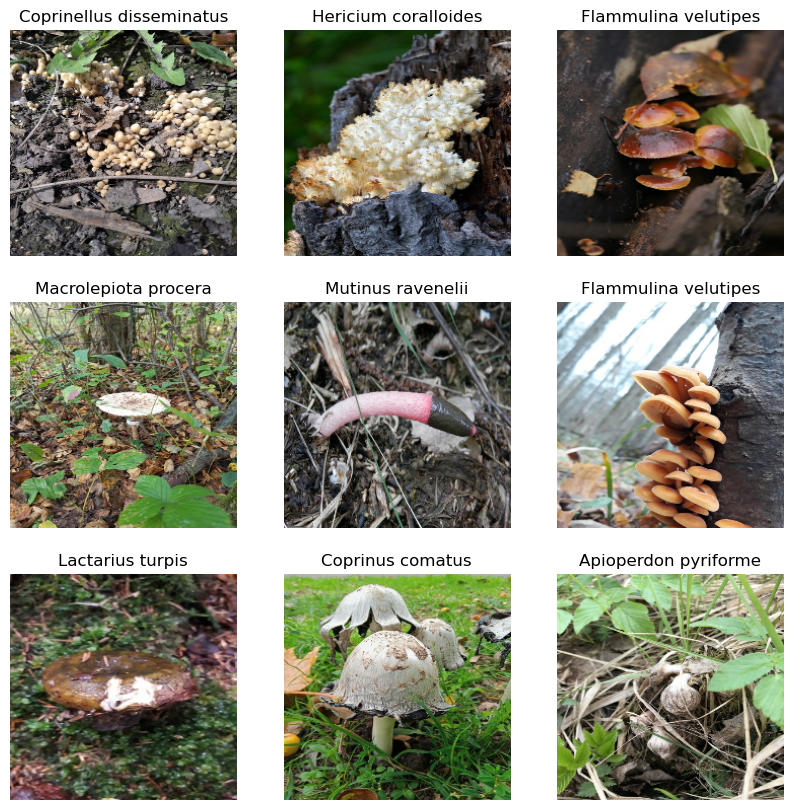

In [8]:
plt.figure(figsize=(10, 10))
for image, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Convert image[i] from float32 to uint8 (0-255 range)
        img = image[i].numpy() * 255.0  # scale back to 0-255
        img = img.astype(np.uint8)      # convert to uint8
        plt.imshow(img)
        plt.title(dataset_categories[labels[i]])
        plt.axis('off')

plt.show()

# 3. Building the Model

## 3.1 Build Stage

In [9]:
from tensorflow.keras.models import Sequential

# Load MobileNetV2 without the top layer to use as the base model
base_model = keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze pre-trained layers
base_model.trainable = False

# Data augmentation block
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(dataset_categories), activation='softmax') 
])


# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    factor=0.5,
    verbose=1,
    min_lr=1e-7
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 100)              

# 4. Training the Model

## 4.1 Training

In [ ]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


## 4.2 Plotting training history

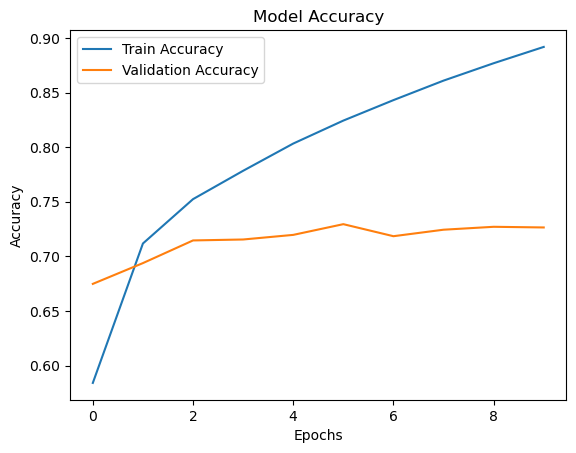

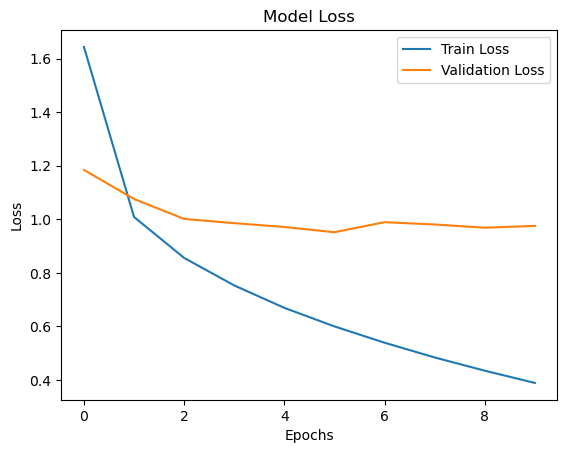

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Evaluating the model

## 5.1 Save/Load Model

In [13]:
model.save("mushroom_classifier.h5")

In [10]:
# optionally load model
model = tf.keras.models.load_model('C:/Documents/ML/models/mushroom_classifier.h5')

## 5.2 Test Model Accuracy

In [10]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

363/363 [==============================] - 48s 59ms/step - loss: 0.9808 - accuracy: 0.7294
Test Loss: 0.9807785153388977
Test Accuracy: 0.7294360995292664


## 5.3 Save/Load Training History

In [14]:
import pickle

# Save
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
# Load
with open('training_history.pkl', 'rb') as f:
    history_data = pickle.load(f)

# Now you can plot it again
import matplotlib.pyplot as plt

plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 6. Fine-tune, retrain model, and test model for better accuracy

## 6.1 Fine-tuning

In [11]:
# Unfreezing the top layers of MobileNetV2
base_model.trainable = True

# Fine-tuning from layer 120
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compiling the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## 6.2 Re-train

In [12]:
# Fine-tuning training
fine_tuned_history = model.fit(
    train_dataset,
    epochs=20, 
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr] 
)

Epoch 1/20
1693/1693 [==============================] - 1004s 539ms/step - loss: 0.2857 - accuracy: 0.9363 - val_loss: 0.9416 - val_accuracy: 0.7358 - lr: 1.0000e-05
Epoch 2/20
1693/1693 [==============================] - 845s 499ms/step - loss: 0.2736 - accuracy: 0.9412 - val_loss: 0.9401 - val_accuracy: 0.7355 - lr: 1.0000e-05
Epoch 3/20
1693/1693 [==============================] - 841s 497ms/step - loss: 0.2677 - accuracy: 0.9437 - val_loss: 0.9421 - val_accuracy: 0.7369 - lr: 1.0000e-05
Epoch 4/20
1693/1693 [==============================] - 845s 499ms/step - loss: 0.2623 - accuracy: 0.9460 - val_loss: 0.9431 - val_accuracy: 0.7342 - lr: 1.0000e-05
Epoch 5/20
1693/1693 [==============================] - 841s 497ms/step - loss: 0.2575 - accuracy: 0.9471 - val_loss: 0.9473 - val_accuracy: 0.7354 - lr: 1.0000e-05
Epoch 6/20
1693/1693 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.9498
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.


In [13]:
model.save("improved_mushroom_classifier.h5")

## 6.3 Plot fine-tuned training history

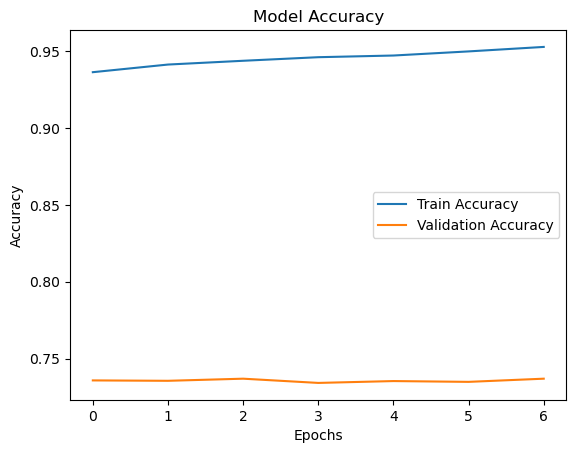

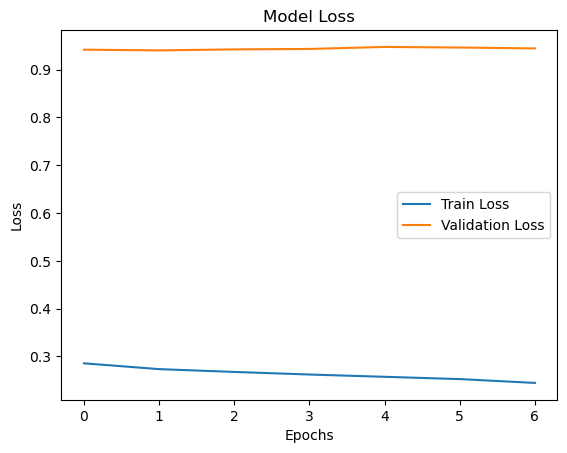

In [14]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(fine_tuned_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tuned_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(fine_tuned_history.history['loss'], label='Train Loss')
plt.plot(fine_tuned_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 6.4 Test Accuracy of fine-tuned model

In [15]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

363/363 [==============================] - 184s 459ms/step - loss: 0.9467 - accuracy: 0.7344
Test Loss: 0.94666588306427
Test Accuracy: 0.7344369888305664


In [ ]:
import pickle

# Save
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)